# <font color='DarkBlue'>Building Recurrent Neural Network

Recurrent Neural Networks (RNN) are very effective for Natural Language Processing and other sequence tasks because they have `memory`. They can read inputs $x^{\langle t \rangle}$ (such as words) one at a time, and remember some information/context through the hidden layer activations that get passed from one time-step to the next. This allows a unidirectional RNN to take information from the past to process later inputs. A bidirectional RNN can take context from both the past and the future. 

**Notation**:
- Superscript $[l]$ denotes an object associated with the $l^{th}$ layer. 

- Superscript $(i)$ denotes an object associated with the $i^{th}$ example. 

- Superscript $\langle t \rangle$ denotes an object at the $t^{th}$ time-step. 
    
- Subscript $i$ denotes the $i^{th}$ entry of a vector.

**Example:**  
$a^{(2)[3]<4>}_5$ denotes the activation of the 2nd training example (2), 3rd layer [3], 4th time step <4>, and 5th entry in the vector.

In [1]:
import numpy as np
from IPython.display import SVG, Image
from rnn_utils import *

## <font color='IndianRed'>Forward propagation for basic RNN

The basic RNN that you will implement has the structure below. In this example, $T_x = T_y$. 

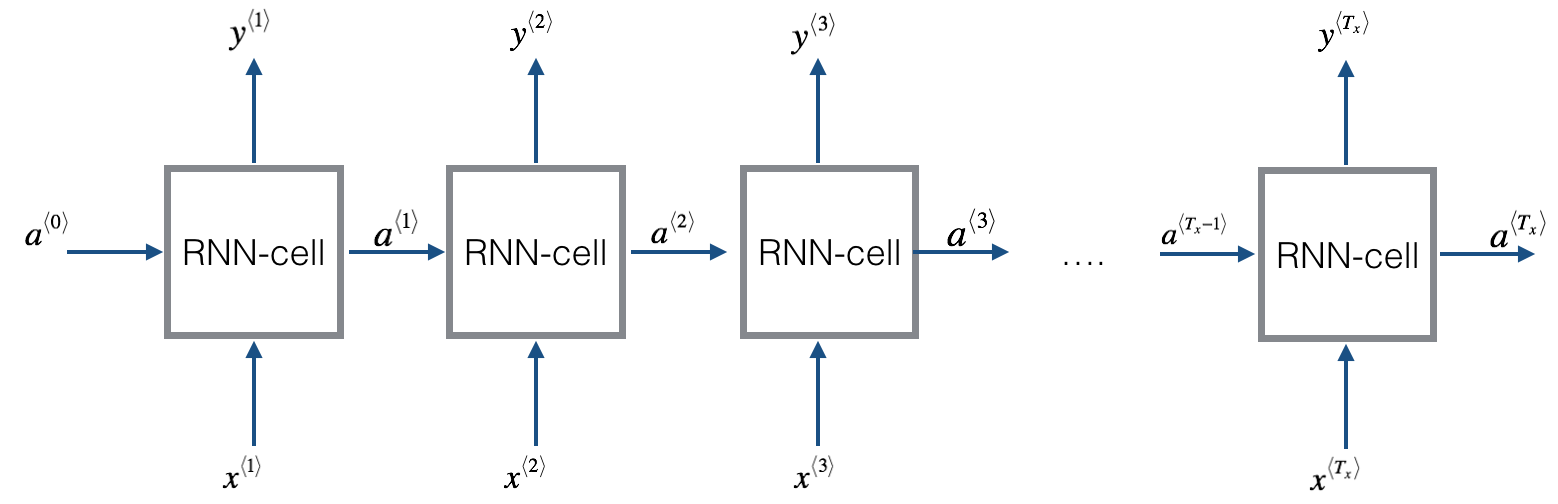

In [2]:
Image(filename="images/RNN.png", width=700, height=750)

### <font color='Indigo'>Dimensions of input

#### <font color='Green'>Input with $n_x$ number of units</font>
* For a single timestep of a single input example, $x^{(i) \langle t \rangle }$ is a one-dimensional input vector. Using language as an example, a language with a 5000-word vocabulary/dictionary could be one-hot encoded into a vector that has 5000 units.  So $x^{(i)\langle t \rangle}$ would have the shape `(5000,)`.  
* We'll use the notation $n_x$ to denote the number of units in a single timestep of a single training example.

#### <font color='Green'>Time steps of size $T_{x}$</font>

* A recurrent neural network has multiple time steps, which we'll index with $t$.
* In the lessons, we saw a single training example $x^{(i)}$ consist of multiple time steps $T_x$.  For example, if there are 10 time steps, $T_{x} = 10$

#### <font color='green'>Batches of size $m$</font>
* Let's say we have mini-batches, each with 20 training examples. To benefit from vectorization, we'll stack 20 columns of $x^{(i)}$ examples. For example, this tensor has the shape `(5000,20,10)`. Logically `[5000, (20,10)]`
* We'll use $m$ to denote the number of training examples. 
* The shape of a mini-batch is $(n_x,m,T_x)$

#### <font color='green'>3D Tensor of shape $(n_{x},m,T_{x})$</font>
* The 3-dimensional tensor $x$ of shape $(n_x,m,T_x)$ represents the input $x$ that is fed into the RNN.

#### <font color='green'>Taking a 2D slice for each time step: $x^{\langle t \rangle}$</font>
At each time step, we'll use a mini-batches of training examples (not just a single example). So, for each time step $t$, we'll use a 2D slice of shape $(n_x,m)$. We're referring to this 2D slice as $x^{\langle t \rangle}$.  The variable name in the code is `xt`.

### <font color='indigo'>Definition of hidden state $a$</font>

* The activation $a^{\langle t \rangle}$ that is passed to the RNN from one time step to another is called a *hidden state*.

### <font color='indigo'>Dimensions of hidden state $a$</font>

* Similar to the input tensor $x$, the hidden state for a single training example is a vector of length $n_{a}$. If we include a mini-batch of $m$ training examples, the shape of a mini-batch is $(n_{a},m)$. When we include the time step dimension, the shape of the hidden state is $(n_{a}, m, T_x)$

* We will loop through the time steps with index $t$, and work with a 2D slice of the 3D tensor. We'll refer to this 2D slice as $a^{\langle t \rangle}$. 
* In the code, the variable names we use are either `a_prev` or `a_next`, depending on the function that's being implemented. The shape of this 2D slice is $(n_{a}, m)$

### <font color='indigo'>Dimensions of prediction $\hat{y}$</font>
* Similar to the inputs and hidden states, $\hat{y}$ is a 3D tensor of shape $(n_{y}, m, T_{y})$.
    * $n_{y}$: number of units in the vector representing the prediction.
    * $m$: number of examples in a mini-batch.
    * $T_{y}$: number of time steps in the prediction.
* For a single time step $t$, a 2D slice $\hat{y}^{\langle t \rangle}$ has shape $(n_{y}, m)$.
* In the code, the variable names are:
    - `y_pred`: $\hat{y}$ 
    - `yt_pred`: $\hat{y}^{\langle t \rangle}$

**Steps for RNN implementation**:
1. Implement the calculations needed for one time-step of the RNN.
2. Implement a loop over $T_x$ time-steps in order to process all the inputs, one at a time. 

## <font color='IndianRed'>RNN cell</font>

A recurrent neural network can be seen as the repeated use of a single cell. You are first going to implement the computations for a single time-step. The following figure describes the operations for a single time-step of an RNN cell.

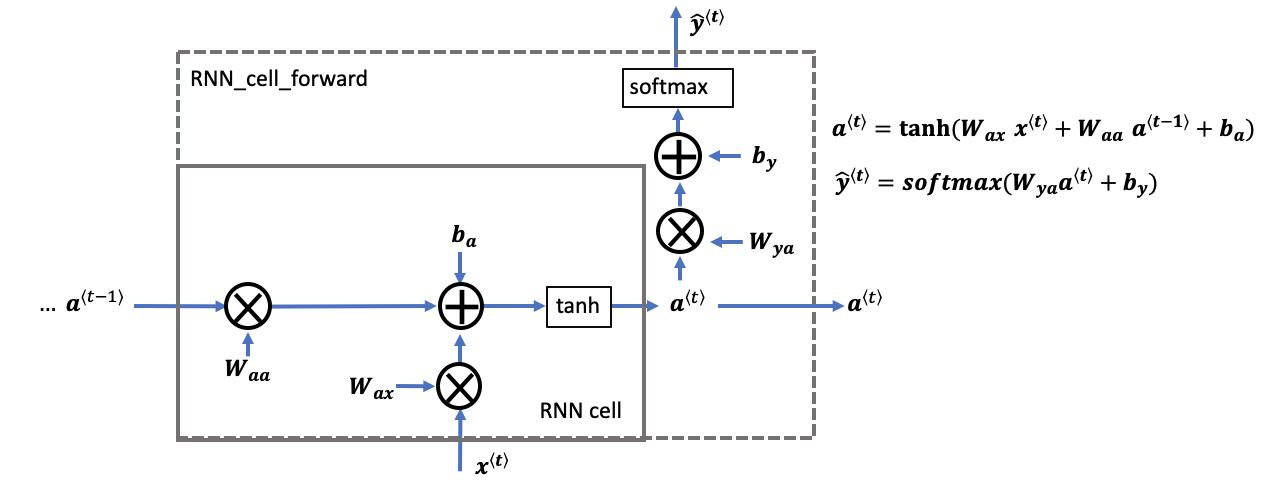

In [3]:
Image(filename="images/rnn_step_forward_figure2_v3a.png", height=500, width=750)

**Description:** Basic RNN cell. Takes as input $x^{\langle t \rangle}$ (current input) and $a^{\langle t - 1\rangle}$ (previous hidden state containing information from the past), and outputs $a^{\langle t \rangle}$ which is given to the next RNN cell and also used to predict $\hat{y}^{\langle t \rangle}$

#### <font color='green'>rnn_cell versus rnn_cell_forward</font>
* Note that an RNN cell outputs the hidden state $a^{\langle t \rangle}$.  
    * The rnn cell is shown in the figure as the inner box which has solid lines.  
* The function that we will implement, `rnn_cell_forward`, also calculates the prediction $\hat{y}^{\langle t \rangle}$
    * The rnn_cell_forward is shown in the figure as the outer box that has dashed lines.

**Exercise**: Implement the RNN-cell described

**Instructions**:
1. Compute the hidden state with tanh activation: $a^{\langle t \rangle} = \tanh(W_{aa} a^{\langle t-1 \rangle} + W_{ax} x^{\langle t \rangle} + b_a)$.
2. Using your new hidden state $a^{\langle t \rangle}$, compute the prediction $\hat{y}^{\langle t \rangle} = softmax(W_{ya} a^{\langle t \rangle} + b_y)$. We provided the function `softmax`.
3. Store $(a^{\langle t \rangle}, a^{\langle t-1 \rangle}, x^{\langle t \rangle}, parameters)$ in a `cache`.
4. Return $a^{\langle t \rangle}$ , $\hat{y}^{\langle t \rangle}$ and `cache`

In [4]:
def rnn_cell_forward(xt, a_prev, parameters):
    """
    Implements a single forward step of the RNN-cell

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
            Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
            Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
            Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
            ba  -- Bias, numpy array of shape (n_a, 1)
            by  -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    
    Returns:
    a_next  -- next hidden state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache   -- tuple of values needed for the backward pass, contains (a_next, a_prev, xt, parameters)
    """
    
    # Retrieve parameters from "parameters"
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]
    
    # compute next activation state using the formula given above
    a_next = np.tanh(np.dot(Waa,a_prev) + np.dot(Wax,xt) + ba)
    # compute output of the current cell using the formula given above
    yt_pred = softmax(np.dot(Wya,a_next) + by)
    
    # store values you need for backward propagation in cache
    cache = (a_next, a_prev, xt, parameters)    
    return a_next, yt_pred, cache

In [5]:
np.random.seed(1)
xt_tmp = np.random.randn(3,10)
a_prev_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Waa'] = np.random.randn(5,5)
parameters_tmp['Wax'] = np.random.randn(5,3)
parameters_tmp['Wya'] = np.random.randn(2,5)
parameters_tmp['ba']  = np.random.randn(5,1)
parameters_tmp['by']  = np.random.randn(2,1)

a_next_tmp, yt_pred_tmp, cache_tmp = rnn_cell_forward(xt_tmp, a_prev_tmp, parameters_tmp)
print("a_next[4]      = ", a_next_tmp[4])
print("a_next.shape   = ", a_next_tmp.shape)
print("yt_pred[1]     = ", yt_pred_tmp[1])
print("yt_pred.shape  = ", yt_pred_tmp.shape)

a_next[4]      =  [ 0.59584544  0.18141802  0.61311866  0.99808218  0.85016201  0.99980978
 -0.18887155  0.99815551  0.6531151   0.82872037]
a_next.shape   =  (5, 10)
yt_pred[1]     =  [ 0.9888161   0.01682021  0.21140899  0.36817467  0.98988387  0.88945212
  0.36920224  0.9966312   0.9982559   0.17746526]
yt_pred.shape  =  (2, 10)


## <font color='IndianRed'>RNN forward pass</font>

- A recurrent neural network (RNN) is a repetition of the RNN cell that you've just built. 
    - If your input sequence of data is 10 time steps long, then you will re-use the RNN cell 10 times. 
- Each cell takes two inputs at each time step:
    - $a^{\langle t-1 \rangle}$: The hidden state from the previous cell.
    - $x^{\langle t \rangle}$: The current time-step's input data.
- It has two outputs at each time step:
    - A hidden state ($a^{\langle t \rangle}$)
    - A prediction ($y^{\langle t \rangle}$)
- The weights and biases $(W_{aa}, b_{a}, W_{ax}, b_{x})$ are re-used each time step. 
    - They are maintained between calls to rnn_cell_forward in the `parameters` dictionary.

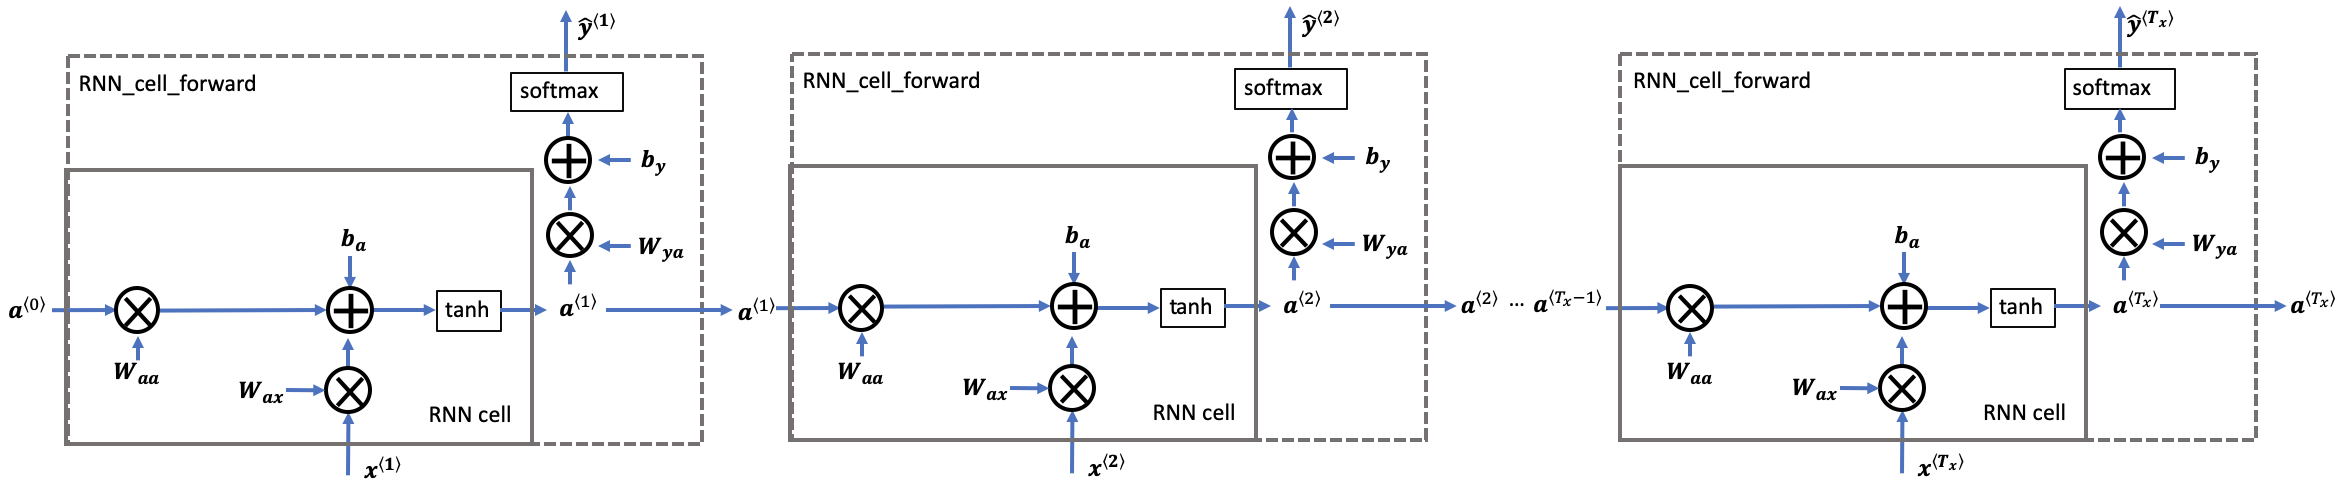

In [6]:
Image(filename="images/rnn_forward_sequence_figure3_v3a.png", height=800, width=900)

**Description**: Basic RNN. The input sequence $x = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$  is carried over $T_x$ time steps. The network outputs $y = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$

**Exercise**: Code the forward propagation of the RNN described

**Instructions**:
* Create a 3D array of zeros, $a$ of shape $(n_{a}, m, T_{x})$ that will store all the hidden states computed by the RNN.
* Create a 3D array of zeros, $\hat{y}$, of shape $(n_{y}, m, T_{x})$ that will store the predictions.  
    - Note that in this case, $T_{y} = T_{x}$ (the prediction and input have the same number of time steps).
* Initialize the 2D hidden state `a_next` by setting it equal to the initial hidden state, $a_{0}$.
* At each time step $t$:
    - Get $x^{\langle t \rangle}$, which is a 2D slice of $x$ for a single time step $t$.
        - $x^{\langle t \rangle}$ has shape $(n_{x}, m)$
        - $x$ has shape $(n_{x}, m, T_{x})$
    - Update the 2D hidden state $a^{\langle t \rangle}$ (variable name `a_next`), the prediction $\hat{y}^{\langle t \rangle}$ and the cache by running `rnn_cell_forward`.
        - $a^{\langle t \rangle}$ has shape $(n_{a}, m)$
    - Store the 2D hidden state in the 3D tensor $a$, at the $t^{th}$ position.
        - $a$ has shape $(n_{a}, m, T_{x})$
    - Store the 2D $\hat{y}^{\langle t \rangle}$ prediction (variable name `yt_pred`) in the 3D tensor $\hat{y}_{pred}$ at the $t^{th}$ position.
        - $\hat{y}^{\langle t \rangle}$ has shape $(n_{y}, m)$
        - $\hat{y}$ has shape $(n_{y}, m, T_x)$
    - Append the cache to the list of caches.
* Return the 3D tensor $a$ and $\hat{y}$, as well as the list of caches.

In [7]:
def rnn_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
            Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
            Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
            Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
            ba  -- Bias numpy array of shape (n_a, 1)
            by  -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a      -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y_pred -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of caches, x)
    """
    
    # Initialize "caches" which will contain the list of all caches
    caches = []
    
    # Retrieve dimensions from shapes of x and parameters["Wya"]
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wya"].shape
    
    # initialize 'a', 'y_pred', 'a_next' with zeros, 
    a      = np.zeros((n_a, m, T_x))
    y_pred = np.zeros((n_y, m, T_x))
    a_next = a0                       # first a<t> to have a0 value, which is 0.
    
    # loop over all time-steps of the input X
    for t in range(T_x):
        xt = x[:,:,t]              # select a time slice (2D slice)
        a_next, yt_pred, cache = rnn_cell_forward(xt, a_next, parameters)
        a[:,:,t] = a_next          # Save the value of the new "next" hidden state in a 
        y_pred[:,:,t] = yt_pred    # Save the value of the prediction in y
        caches.append(cache)       # Append "cache" to "caches"
           
    # store values needed for backward propagation in cache
    caches = (caches, x)
    return a, y_pred, caches

In [8]:
np.random.seed(1)
x_tmp = np.random.randn(3,10,4)
a0_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Waa'] = np.random.randn(5,5)
parameters_tmp['Wax'] = np.random.randn(5,3)
parameters_tmp['Wya'] = np.random.randn(2,5)
parameters_tmp['ba']  = np.random.randn(5,1)
parameters_tmp['by']  = np.random.randn(2,1)

a_tmp, y_pred_tmp, caches_tmp = rnn_forward(x_tmp, a0_tmp, parameters_tmp)
print("a[4][1]         = ", a_tmp[4][1])
print("a.shape         = ", a_tmp.shape)
print("y_pred[1][3]    = ", y_pred_tmp[1][3])
print("y_pred.shape    = ", y_pred_tmp.shape)
print("caches[1][1][3] = ", caches_tmp[1][1][3])
print("len(caches)     = ", len(caches_tmp))

a[4][1]         =  [-0.99999375  0.77911235 -0.99861469 -0.99833267]
a.shape         =  (5, 10, 4)
y_pred[1][3]    =  [ 0.79560373  0.86224861  0.11118257  0.81515947]
y_pred.shape    =  (2, 10, 4)
caches[1][1][3] =  [-1.1425182  -0.34934272 -0.20889423  0.58662319]
len(caches)     =  2


#### Situations when this RNN will perform better:
- This will work well enough for some applications, but it suffers from the vanishing gradient problems. 
- The RNN works best when each output $\hat{y}^{\langle t \rangle}$ can be estimated using local context. Local context refers to information that is close to the prediction's time step $t$. More formally, local context refers to inputs $x^{\langle t' \rangle}$ and predictions $\hat{y}^{\langle t \rangle}$ where $t'$ is close to $t$.

## <font color='IndianRed'>Long Short-Term Memory (LSTM) network </font>

LSTM-cell tracks and updates a `cell state` or memory variable $c^{\langle t \rangle}$ at every time-step, which can be different from $a^{\langle t \rangle}$. Note, the $softmax^{*}$ includes a dense layer and softmax. The following figure shows the operations of an LSTM-cell.

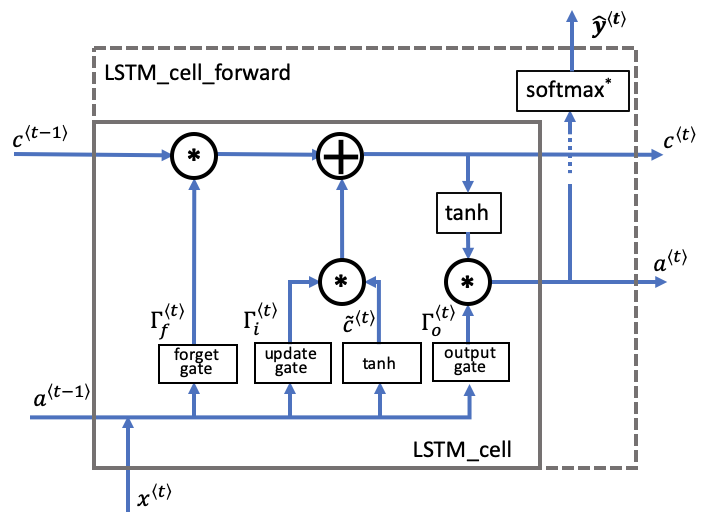

In [9]:
Image(filename="images/LSTM_figure4_v3a.png", height=300, width=500)

### <font color='Indigo'>Overview of gates and states</font>

#### <font color='green'>Forget gate $\mathbf{\Gamma}_{f}$</font>

* Let's assume we are reading words in a piece of text, and plan to use an LSTM to keep track of grammatical structures, such as whether the subject is singular or plural. 
* If the subject changes its state (from a singular word to a plural word), the memory of the previous state becomes outdated, so we forget that outdated state.
* The 'forget gate' is a tensor containing values that are between 0 and 1.
    * If a unit in the forget gate has a value close to 0, the LSTM will forget the stored state in the corresponding unit of the previous cell state.
    * If a unit in the forget gate has a value close to 1, the LSTM will remember the corresponding value in the stored state.

##### <font color='green'>Equation</font>

$$\mathbf{\Gamma}_f^{\langle t \rangle} = \sigma(\mathbf{W}_f[\mathbf{a}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_f)$$

##### <font color='green'>Explanation of the equation:</font>

* $\mathbf{W_{f}}$ contains weights that govern the forget gate's behavior. The previous time step's hidden state $[a^{\langle t-1 \rangle}$ and current time step's input $x^{\langle t \rangle}]$ are concatenated together and multiplied by $\mathbf{W_{f}}$. A sigmoid function is used to make each of the gate tensor's values $\mathbf{\Gamma}_f^{\langle t \rangle}$ range from 0 to 1.
* The forget gate  $\mathbf{\Gamma}_f^{\langle t \rangle}$ has the same dimensions as the previous cell state $c^{\langle t-1 \rangle}$. This means that the two can be multiplied together, element-wise.
* Multiplying the tensors $\mathbf{\Gamma}_f^{\langle t \rangle} \cdot \mathbf{c}^{\langle t-1 \rangle}$ is like applying a mask over the previous cell state. 
    * If a single value in $\mathbf{\Gamma}_f^{\langle t \rangle}$ is 0 or close to 0, then the product is close to 0. This keeps the information stored in the corresponding unit in $\mathbf{c}^{\langle t-1 \rangle}$ from being remembered for the next time step.
    * Similarly, if one value is close to 1, the product is close to the original value in the previous cell state. The LSTM will keep the information from the corresponding unit of $\mathbf{c}^{\langle t-1 \rangle}$, to be used in the next time step.
    
##### <font color='green'>Variable names in the code</font>

* `Wf`: forget gate weight $\mathbf{W}_{f}$
* `bf`: forget gate bias $\mathbf{b}_{f}$
* `ft`: forget gate $\Gamma_f^{\langle t \rangle}$

#### <font color='blue'>Candidate value $\tilde{\mathbf{c}}^{\langle t \rangle}$</font>
The candidate value is a tensor containing information from the current time step that *may* be stored in the current cell state $\mathbf{c}^{\langle t \rangle}$. Which candidate value get passed on depends on the update gate. The candidate value is a tensor containing values that range from -1 to 1. The tilde `~` is used to differentiate the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ from the cell state $\mathbf{c}^{\langle t \rangle}$.

##### <font color='blue'>Equation</font>
$$\mathbf{\tilde{c}}^{\langle t \rangle} = \tanh\left( \mathbf{W}_{c} [\mathbf{a}^{\langle t - 1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{c} \right)$$

##### <font color='blue'>Explanation of the equation</font>
The 'tanh' function produces values between -1 and +1.

##### <font color='blue'>Variable names in the code</font>
`cct`: candidate value $\mathbf{\tilde{c}}^{\langle t \rangle}$

#### <font color='DarkMagenta'>Update gate $\mathbf{\Gamma}_{i}$</font>

* We use the update gate to decide what aspects of the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ to add to the cell state $c^{\langle t \rangle}$. The update gate decides what parts of a "candidate" tensor $\tilde{\mathbf{c}}^{\langle t \rangle}$ are passed onto the cell state $\mathbf{c}^{\langle t \rangle}$.
* The update gate is a tensor containing values between 0 and 1.
    * When a unit in the update gate is close to 1, it allows the value of the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ to be passed onto the hidden state $\mathbf{c}^{\langle t \rangle}$
    * When a unit in the update gate is close to 0, it prevents the corresponding value in the candidate from being passed onto the hidden state.

##### <font color='DarkMagenta'>Equation</font>

$$\mathbf{\Gamma}_i^{\langle t \rangle} = \sigma(\mathbf{W}_i[a^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_i)$$ 

##### <font color='DarkMagenta'>Explanation of the equation</font>

* Similar to the forget gate, here $\mathbf{\Gamma}_i^{\langle t \rangle}$, the sigmoid produces values between 0 and 1.
* The update gate is multiplied element-wise with the candidate, and this product ($\mathbf{\Gamma}_{i}^{\langle t \rangle} * \tilde{c}^{\langle t \rangle}$) is used in determining the cell state $\mathbf{c}^{\langle t \rangle}$.

##### <font color='DarkMagenta'>Variable names in code</font>

* `Wi` is the update gate weight $\mathbf{W}_i$
* `bi` is the update gate bias $\mathbf{b}_i$
* `it` is the forget gate $\mathbf{\Gamma}_i^{\langle t \rangle}$

#### <font color='forestgreen'>Cell State $\mathbf{c}^{\langle t \rangle}$</font>

* The cell state is the memory that gets passed onto future time steps.
* The new cell state $\mathbf{c}^{\langle t \rangle}$ is a combination of the previous cell state and the candidate value.

##### <font color='forestgreen'>Equation</font>

$$ \mathbf{c}^{\langle t \rangle} = \mathbf{\Gamma}_f^{\langle t \rangle}* \mathbf{c}^{\langle t-1 \rangle} + \mathbf{\Gamma}_{i}^{\langle t \rangle} *\mathbf{\tilde{c}}^{\langle t \rangle}$$

##### <font color='forestgreen'>Explanation of equation</font>
* The previous cell state $\mathbf{c}^{\langle t-1 \rangle}$ is adjusted (weighted) by the forget gate $\mathbf{\Gamma}_{f}^{\langle t \rangle}$
* The candidate value $\tilde{\mathbf{c}}^{\langle t \rangle}$, adjusted (weighted) by the update gate $\mathbf{\Gamma}_{i}^{\langle t \rangle}$

##### <font color='forestgreen'>Variable names and shapes in the code</font>
* `c`: cell state, including all time steps, $\mathbf{c}$ shape $(n_{a}, m, T)$
* `c_next`: new (next) cell state, $\mathbf{c}^{\langle t \rangle}$ shape $(n_{a}, m)$
* `c_prev`: previous cell state, $\mathbf{c}^{\langle t-1 \rangle}$, shape $(n_{a}, m)$

#### <font color='Maroon'>$\mathbf{\Gamma}_{o}$</font>

* The output gate decides what gets sent as the prediction (output) of the time step.
* The output gate is like the other gates. It contains values that range from 0 to 1.

##### <font color='Maroon'>Equation</font>

$$ \mathbf{\Gamma}_o^{\langle t \rangle}=  \sigma(\mathbf{W}_o[\mathbf{a}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{o})$$ 

##### <font color='Maroon'>Explanation of the equation</font>
* The output gate is determined by the previous hidden state $\mathbf{a}^{\langle t-1 \rangle}$ and the current input $\mathbf{x}^{\langle t \rangle}$
* The sigmoid makes the gate range from 0 to 1.


##### <font color='Maroon'>Variable names in the code</font>
* `Wo`: output gate weight, $\mathbf{W_o}$
* `bo`: output gate bias, $\mathbf{b_o}$
* `ot`: output gate, $\mathbf{\Gamma}_{o}^{\langle t \rangle}$

#### <font color='MediumBlue'>Hidden state $\mathbf{a}^{\langle t \rangle}$</font>

* The hidden state gets passed to the LSTM cell's next time step.
* It is used to determine the three gates ($\mathbf{\Gamma}_{f}, \mathbf{\Gamma}_{u}, \mathbf{\Gamma}_{o}$) of the next time step.
* The hidden state is also used for the prediction $y^{\langle t \rangle}$.

##### <font color='MediumBlue'>Equation</font>

$$ \mathbf{a}^{\langle t \rangle} = \mathbf{\Gamma}_o^{\langle t \rangle} * \tanh(\mathbf{c}^{\langle t \rangle}) $$

##### <font color='MediumBlue'>Explanation of equation</font>
* The hidden state $\mathbf{a}^{\langle t \rangle}$ is determined by the cell state $\mathbf{c}^{\langle t \rangle}$ in combination with the output gate $\mathbf{\Gamma}_{o}$.
* The cell state state is passed through the "tanh" function to rescale values between -1 and +1.
* The output gate acts like a "mask" that either preserves the values of $\tanh(\mathbf{c}^{\langle t \rangle})$ or keeps those values from being included in the hidden state $\mathbf{a}^{\langle t \rangle}$

##### <font color='MediumBlue'>Variable names and shapes in the code</font>
* `a`: hidden state, including time steps.  $\mathbf{a}$ has shape $(n_{a}, m, T_{x})$
* `a_prev`: hidden state from previous time step. $\mathbf{a}^{\langle t-1 \rangle}$ has shape $(n_{a}, m)$
* `a_next`: hidden state for next time step.  $\mathbf{a}^{\langle t \rangle}$ has shape $(n_{a}, m)$ 

#### <font color='Olivedrab'>Prediction $\mathbf{y}^{\langle t \rangle}_{pred}$</font>
The prediction in this use case is a classification, so we'll use a softmax. The equation is:
$$\mathbf{y}^{\langle t \rangle}_{pred} = \textrm{softmax}(\mathbf{W}_{y} \mathbf{a}^{\langle t \rangle} + \mathbf{b}_{y})$$

##### <font color='Olivedrab'>Variable names and shapes in the code</font>
* `y_pred`: prediction, including all time steps. $\mathbf{y}_{pred}$ has shape $(n_{y}, m, T_{x})$.  Note that $(T_{y} = T_{x})$ for this example.
* `yt_pred`: prediction for the current time step. $\mathbf{y}^{\langle t \rangle}_{pred}$ has shape $(n_{y}, m)$

### <font color='Indigo'>LSTM cell</font>

**Exercise**: Implement the LSTM cell

**Instructions**:
* Concatenate the hidden state $a^{\langle t-1 \rangle}$ and input $x^{\langle t \rangle}$ into a single matrix:  

$$concat = \begin{bmatrix} a^{\langle t-1 \rangle} \\ x^{\langle t \rangle} \end{bmatrix}$$  

* Compute all the formulas 1 through 6 for the gates, hidden state, and cell state.
* Compute the prediction $y^{\langle t \rangle}$.

In [10]:
def lstm_cell_forward(xt, a_prev, c_prev, parameters):
    """
    Implement a single forward step of the LSTM-cell as described in Figure (4)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
            Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
            bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
            Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
            bi -- Bias of the update gate, numpy array of shape (n_a, 1)
            Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
            bc --  Bias of the first "tanh", numpy array of shape (n_a, 1)
            Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
            bo --  Bias of the output gate, numpy array of shape (n_a, 1)
            Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
            by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a_next  -- next hidden state, of shape (n_a, m)
    c_next  -- next memory state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache   -- tuple of values needed for the backward pass, 
               contains (a_next, c_next, a_prev, c_prev, xt, parameters)
    
    Note: ft/it/ot stand for the forget/update/output gates, cct stands for the candidate value (c tilde),
          c stands for the cell state (memory)
    """

    # Retrieve parameters from "parameters"
    Wf = parameters["Wf"] # forget gate weight
    bf = parameters["bf"]
    Wi = parameters["Wi"] # update gate weight (notice the variable name)
    bi = parameters["bi"] # (notice the variable name)
    Wc = parameters["Wc"] # candidate value weight
    bc = parameters["bc"]
    Wo = parameters["Wo"] # output gate weight
    bo = parameters["bo"]
    Wy = parameters["Wy"] # prediction weight
    by = parameters["by"]
    
    # Retrieve dimensions from shapes of xt and Wy
    n_x, m   = xt.shape
    n_y, n_a = Wy.shape

    # Concatenate a_prev and xt
    concat = np.zeros((n_a + n_x, m))
    concat[: n_a, :] = a_prev
    concat[n_a :, :] = xt

    # Compute values for ft (forget gate), it (update gate),
    # cct (candidate value), c_next (cell state), 
    # ot (output gate), a_next (hidden state)
    
    ft = sigmoid(np.dot(Wf,concat) + bf)        # forget gate
    it = sigmoid(np.dot(Wi,concat) + bi)        # update gate
    cct    = np.tanh(np.dot(Wc,concat) + bc)    # candidate value
    c_next = ft * c_prev + it * cct             # cell state
    ot     = sigmoid(np.dot(Wo,concat) + bo)    # output gate
    a_next = ot * np.tanh(c_next)               # hidden state
    
    # Compute prediction of the LSTM cell
    yt_pred = softmax(np.dot(Wy,a_next) + by)
    
    cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)
    return a_next, c_next, yt_pred, cache

In [11]:
np.random.seed(1)
xt_tmp = np.random.randn(3,10)
a_prev_tmp = np.random.randn(5,10)
c_prev_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5+3)
parameters_tmp['bf'] = np.random.randn(5,1)
parameters_tmp['Wi'] = np.random.randn(5, 5+3)
parameters_tmp['bi'] = np.random.randn(5,1)
parameters_tmp['Wo'] = np.random.randn(5, 5+3)
parameters_tmp['bo'] = np.random.randn(5,1)
parameters_tmp['Wc'] = np.random.randn(5, 5+3)
parameters_tmp['bc'] = np.random.randn(5,1)
parameters_tmp['Wy'] = np.random.randn(2,5)
parameters_tmp['by'] = np.random.randn(2,1)

a_next_tmp, c_next_tmp, yt_tmp, cache_tmp = lstm_cell_forward(xt_tmp, a_prev_tmp, c_prev_tmp, parameters_tmp)
print("a_next[4]    = ", a_next_tmp[4])
print("a_next.shape = ", a_next_tmp.shape)
print("c_next[2]    = ", c_next_tmp[2])
print("c_next.shape = ", c_next_tmp.shape)
print("yt[1]        = ", yt_tmp[1])
print("yt.shape     = ", yt_tmp.shape)
print("cache[1][3]  = ", cache_tmp[1][3])
print("len(cache)   = ", len(cache_tmp))

a_next[4]    =  [-0.66408471  0.0036921   0.02088357  0.22834167 -0.85575339  0.00138482
  0.76566531  0.34631421 -0.00215674  0.43827275]
a_next.shape =  (5, 10)
c_next[2]    =  [ 0.63267805  1.00570849  0.35504474  0.20690913 -1.64566718  0.11832942
  0.76449811 -0.0981561  -0.74348425 -0.26810932]
c_next.shape =  (5, 10)
yt[1]        =  [ 0.79913913  0.15986619  0.22412122  0.15606108  0.97057211  0.31146381
  0.00943007  0.12666353  0.39380172  0.07828381]
yt.shape     =  (2, 10)
cache[1][3]  =  [-0.16263996  1.03729328  0.72938082 -0.54101719  0.02752074 -0.30821874
  0.07651101 -1.03752894  1.41219977 -0.37647422]
len(cache)   =  10


### <font color='indigo'>Forward pass for LSTM</font>

Now that you have implemented one step of an LSTM, you can now iterate this over this using a for-loop to process a sequence of $T_x$ inputs. 

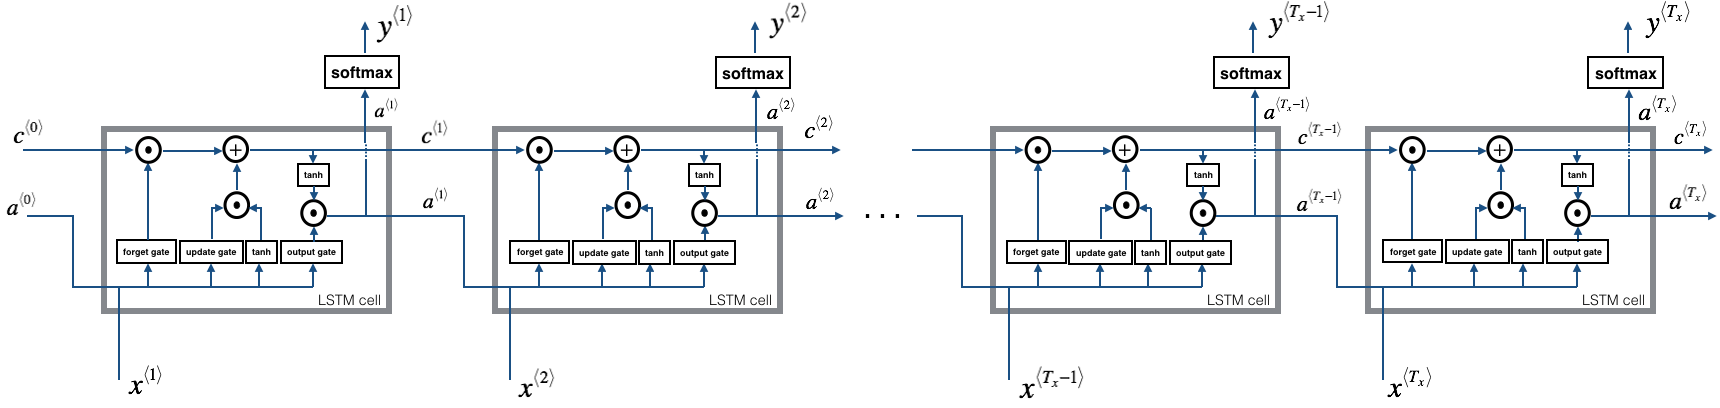

In [12]:
Image(filename="images/LSTM_rnn.png", width=900, height=350)

**Exercise:** Implement `lstm_forward()` to run an LSTM over $T_x$ time-steps. 

**Instructions**
* Get the dimensions $n_x, n_a, n_y, m, T_x$ from the shape of the variables: `x` and `parameters`.
* Initialize the 3D tensors $a$, $c$ and $y$.
    - $a$: hidden state, shape $(n_{a}, m, T_{x})$
    - $c$: cell state, shape $(n_{a}, m, T_{x})$
    - $y$: prediction, shape $(n_{y}, m, T_{x})$ (Note that $T_{y} = T_{x}$ in this example).
    - **Note** Setting one variable equal to the other is a "copy by reference".  In other words, don't do `c = a`, otherwise both these variables point to the same underlying variable.
    
* Initialize the 2D tensor $a^{\langle t \rangle}$ 
    - $a^{\langle t \rangle}$ stores the hidden state for time step $t$.  The variable name is `a_next`.
    - $a^{\langle 0 \rangle}$, the initial hidden state at time step 0, is passed in when calling the function. The variable name is `a0`.
    - $a^{\langle t \rangle}$ and $a^{\langle 0 \rangle}$ represent a single time step, so they both have the shape  $(n_{a}, m)$ 
    - Initialize $a^{\langle t \rangle}$ by setting it to the initial hidden state ($a^{\langle 0 \rangle}$) that is passed into the function.
* Initialize $c^{\langle t \rangle}$ with zeros. 
    - The variable name is `c_next`. 
    - $c^{\langle t \rangle}$ represents a single time step, so its shape is $(n_{a}, m)$
    - **Note**: create `c_next` as its own variable with its own location in memory.  Do not initialize it as a slice of the 3D tensor $c$.  In other words, **don't** do `c_next = c[:,:,0]`.
* For each time step, do the following:
    - From the 3D tensor $x$, get a 2D slice $x^{\langle t \rangle}$ at time step $t$.
    - Call the `lstm_cell_forward` function that you defined previously, to get the hidden state, cell state, prediction, and cache.
    - Store the hidden state, cell state and prediction (the 2D tensors) inside the 3D tensors.
    - Append the cache to the list of caches.

In [13]:
def lstm_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network using an LSTM-cell

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
            Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
            bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
            Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
            bi -- Bias of the update gate, numpy array of shape (n_a, 1)
            Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
            bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
            Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
            bo -- Bias of the output gate, numpy array of shape (n_a, 1)
            Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
            by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    c -- The value of the cell state, numpy array of shape (n_a, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of all caches, x)
    """

    # Initialize "caches", which will track the list of all the caches
    caches = []
    
    Wy = parameters['Wy'] # saving parameters['Wy'] in a local variable
    # Retrieve dimensions from shapes of x and parameters['Wy']
    n_x, m, T_x = x.shape
    n_y, n_a    = Wy.shape
    
    # initialize "a", "c" and "y" with zeros
    a = np.zeros((n_a, m, T_x))
    c = np.zeros((n_a, m, T_x))
    y = np.zeros((n_y, m, T_x))
    
    # Initialize a_next and c_next
    a_next = a0
    c_next = np.zeros((n_a,m))
    
    # loop over all time-steps
    for t in range(T_x):
        xt = x[:,:,t]
        # Update next hidden state, next memory state, compute the prediction, get cache
        a_next, c_next, yt, cache = lstm_cell_forward(xt, a_next, c_next, parameters)
    
        a[:,:,t] = a_next
        c[:,:,t] = c_next
        y[:,:,t] = yt
        caches.append(cache)
        
    # store values needed for backward propagation in cache
    caches = (caches, x)
    return a, y, c, caches

In [14]:
np.random.seed(1)
x_tmp = np.random.randn(3,10,7)
a0_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5+3)
parameters_tmp['bf'] = np.random.randn(5,1)
parameters_tmp['Wi'] = np.random.randn(5, 5+3)
parameters_tmp['bi']= np.random.randn(5,1)
parameters_tmp['Wo'] = np.random.randn(5, 5+3)
parameters_tmp['bo'] = np.random.randn(5,1)
parameters_tmp['Wc'] = np.random.randn(5, 5+3)
parameters_tmp['bc'] = np.random.randn(5,1)
parameters_tmp['Wy'] = np.random.randn(2,5)
parameters_tmp['by'] = np.random.randn(2,1)

a_tmp, y_tmp, c_tmp, caches_tmp = lstm_forward(x_tmp, a0_tmp, parameters_tmp)
print("a[4][3][6]  = ", a_tmp[4][3][6])
print("a.shape     = ", a_tmp.shape)
print("y[1][4][3]  = ", y_tmp[1][4][3])
print("y.shape     = ", y_tmp.shape)
print("caches[1][1][1] =\n", caches_tmp[1][1][1])
print("c[1][2][1]  = ", c_tmp[1][2][1])
print("len(caches) = ", len(caches_tmp))

a[4][3][6]  =  0.172117767533
a.shape     =  (5, 10, 7)
y[1][4][3]  =  0.95087346185
y.shape     =  (2, 10, 7)
caches[1][1][1] =
 [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
c[1][2][1]  =  -0.855544916718
len(caches) =  2


## <font color='IndianRed'>Backpropagation in RNN</font>

This section is optional, ungraded, more difficult and has fewer details regarding its implementation. (Only implements key elements of the full path).

### <font color='indigo'>Basic RNN Backward pass</font>

We will start by computing the backward pass for the basic RNN-cell and then in the following sections, iterate through the cells.

Just like in a fully-connected neural network, the derivative of the cost function $J$ backpropagates through the time steps of the RNN by following the chain-rule from calculus. Internal to the cell, the chain-rule is also used to calculate $(\frac{\partial J}{\partial W_{ax}},\frac{\partial J}{\partial W_{aa}},\frac{\partial J}{\partial b})$ to update the parameters $(W_{ax}, W_{aa}, b_a)$. The operation can utilize the cached results from the forward path.

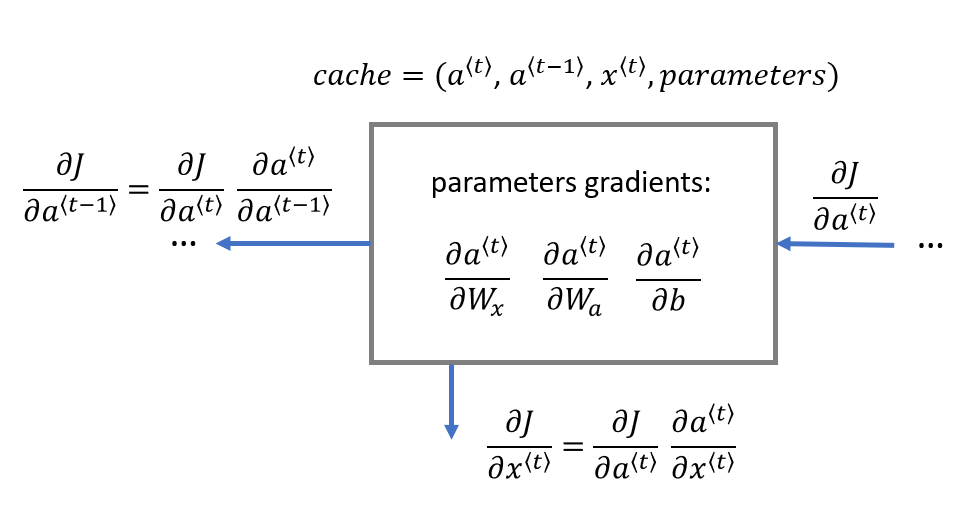

In [15]:
Image(filename="images/rnn_backward_overview_3a_1.png", width=700, height=400)

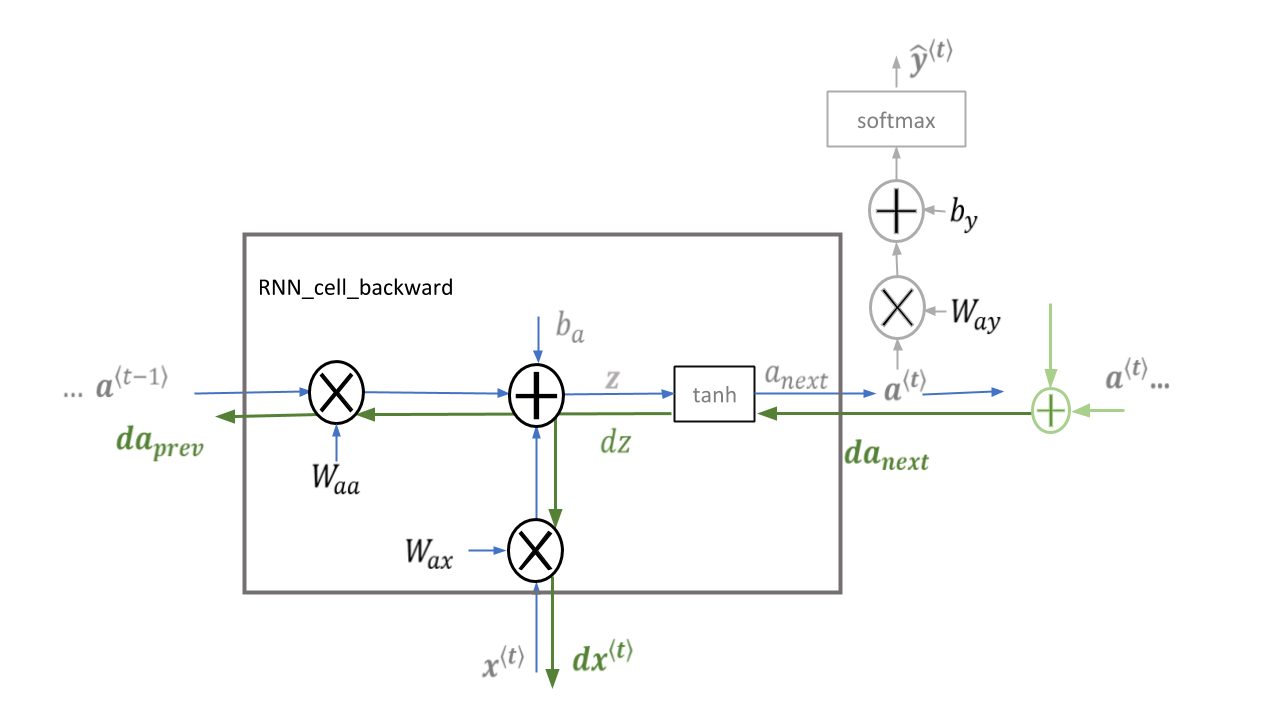

In [16]:
Image(filename="images/rnn_cell_backward_3a_c.png", width=700, height=400)

This implementation of rnn_cell_backward does **not** include the output dense layer and softmax which are included in `rnn_cell_forward`.  

$da_{next}$ is $\frac{\partial{J}}{\partial a^{\langle t \rangle}}$ and includes loss from previous stages and current stage output logic. The addition shown in green will be part of your implementation of rnn_backward.  </center></caption>

##### Equations
To compute the `rnn_cell_backward` you can utilize the following equations. It is a good exercise to derive them by hand. Here, $*$ denotes element-wise multiplication while the absence of a symbol indicates matrix multiplication.

\begin{align}
\displaystyle a^{\langle t\rangle} &= \tanh(W_{ax} x^{\langle t \rangle} + W_{aa} a^{\langle t-1 \rangle} + b_{a}) \\[8pt]
\displaystyle \frac{\partial \tanh(x)} {\partial x} &= 1 - \tanh^2(x)\\[8pt]
\displaystyle  {dW_{ax}} &= (da_{next} * ( 1-\tanh^2(W_{ax}x^{\langle t \rangle}+W_{aa} a^{\langle t-1 \rangle} + b_{a}) )) x^{\langle t \rangle T}\\[8pt]
\displaystyle dW_{aa} &= (da_{next} * ( 1-\tanh^2(W_{ax}x^{\langle t \rangle}+W_{aa} a^{\langle t-1 \rangle} + b_{a}) ))  a^{\langle t-1 \rangle T}\\[8pt]
\displaystyle db_a& = \sum_{batch}( da_{next} * ( 1-\tanh^2(W_{ax}x^{\langle t \rangle}+W_{aa} a^{\langle t-1 \rangle} + b_{a}) )) \\[8pt]
\displaystyle dx^{\langle t \rangle} &= { W_{ax}}^T (da_{next} * ( 1-\tanh^2(W_{ax}x^{\langle t \rangle}+W_{aa} a^{\langle t-1 \rangle} + b_{a}) )) \\[8pt]
\displaystyle da_{prev} &= { W_{aa}}^T(da_{next} *  ( 1-\tanh^2(W_{ax}x^{\langle t \rangle}+W_{aa} a^{\langle t-1 \rangle} + b_{a}) ))
\end{align}



#### Implementing `rnn_cell_backward`
The results can be computed directly by implementing the equations above. However, the above can optionally be simplified by computing `dz` and utlilizing the chain rule.  This can be further simplified by noting that $\tanh(W_{ax}x^{\langle t \rangle}+W_{aa} a^{\langle t-1 \rangle} + b_{a})$ was computed and saved in the forward pass. 

To calculate dba, the `batch` above is a sum across all `m` examples (axis= 1). Note that you should use the `keepdims = True` option. Matrix vector derivatives are described [here](http://cs231n.stanford.edu/vecDerivs.pdf), though the equations above incorporate the required transformations.

Note `rnn_cell_backward` does not include the calculation of loss from $y \langle t \rangle$, this is incorporated into the incoming `da_next`. This is a slight mismatch with `rnn_cell_forward` which includes a dense layer and softmax. 

Note: in the code:

$\displaystyle dx^{\langle t \rangle}$ is represented by dxt,   
$\displaystyle d W_{ax}$ is represented by dWax,   
$\displaystyle da_{prev}$ is represented by da_prev,    
$\displaystyle dW_{aa}$ is represented by dWaa,   
$\displaystyle db_{a}$ is represented by dba

In [17]:
def rnn_cell_backward(da_next, cache):
    """
    Implements the backward pass for the RNN-cell (single time-step).

    Arguments:
    da_next -- Gradient of loss with respect to next hidden state
    cache -- python dictionary containing useful values (output of rnn_cell_forward())

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradients of input data, of shape (n_x, m)
                        da_prev -- Gradients of previous hidden state, of shape (n_a, m)
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dba -- Gradients of bias vector, of shape (n_a, 1)
    """
    
    # Retrieve values from cache
    (a_next, a_prev, xt, parameters) = cache
    
    # Retrieve values from parameters
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]

    
    # compute the gradient of the loss with respect to z
    dz = (1-a_next**2) * da_next

    # compute the gradient of the loss with respect to Wax
    dxt  = np.dot(Wax.T, dz)
    dWax = np.dot(dz, xt.T)

    # compute the gradient with respect to Waa
    da_prev = np.dot(Waa.T, dz)
    dWaa    = np.dot(dz, a_prev.T)

    # compute the gradient with respect to b
    dba = np.sum(dz, keepdims=True, axis= -1)
        
    # Store the gradients in a python dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dWax": dWax, "dWaa": dWaa, "dba": dba}
    return gradients

In [18]:
np.random.seed(1)
xt_tmp = np.random.randn(3,10)
a_prev_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wax'] = np.random.randn(5,3)
parameters_tmp['Waa'] = np.random.randn(5,5)
parameters_tmp['Wya'] = np.random.randn(2,5)
parameters_tmp['ba']  = np.random.randn(5,1)
parameters_tmp['by']  = np.random.randn(2,1)

a_next_tmp, yt_tmp, cache_tmp = rnn_cell_forward(xt_tmp, a_prev_tmp, parameters_tmp)

da_next_tmp = np.random.randn(5,10)
gradients_tmp = rnn_cell_backward(da_next_tmp, cache_tmp)
print("gradients[\"dxt\"][1][2]     =", gradients_tmp["dxt"][1][2])
print("gradients[\"dxt\"].shape     =", gradients_tmp["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients_tmp["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients_tmp["da_prev"].shape)
print("gradients[\"dWax\"][3][1]    =", gradients_tmp["dWax"][3][1])
print("gradients[\"dWax\"].shape    =", gradients_tmp["dWax"].shape)
print("gradients[\"dWaa\"][1][2]    =", gradients_tmp["dWaa"][1][2])
print("gradients[\"dWaa\"].shape    =", gradients_tmp["dWaa"].shape)
print("gradients[\"dba\"][4]        =", gradients_tmp["dba"][4])
print("gradients[\"dba\"].shape     =", gradients_tmp["dba"].shape)

gradients["dxt"][1][2]     = -1.3872130506
gradients["dxt"].shape     = (3, 10)
gradients["da_prev"][2][3] = -0.152399493774
gradients["da_prev"].shape = (5, 10)
gradients["dWax"][3][1]    = 0.410772824935
gradients["dWax"].shape    = (5, 3)
gradients["dWaa"][1][2]    = 1.15034506685
gradients["dWaa"].shape    = (5, 5)
gradients["dba"][4]        = [ 0.20023491]
gradients["dba"].shape     = (5, 1)


#### Backward pass through the RNN

Computing the gradients of the cost with respect to $a^{\langle t \rangle}$ at every time-step $t$ is useful because it is what helps the gradient backpropagate to the previous RNN-cell. To do so, you need to iterate through all the time steps starting at the end, and at each step, you increment the overall $db_a$, $dW_{aa}$, $dW_{ax}$ and you store $dx$.

**Instructions**:

Implement the `rnn_backward` function. Initialize the return variables with zeros first and then loop through all the time steps while calling the `rnn_cell_backward` at each time timestep, update the other variables accordingly.

* Note that this notebook does not implement the backward path from the Loss 'J' backwards to 'a'. 
    * This would have included the dense layer and softmax which are a part of the forward path. 
    * This is assumed to be calculated elsewhere and the result passed to rnn_backward in 'da'. 
    * You must combine this with the loss from the previous stages when calling rnn_cell_backward.
* It is further assumed that loss has been adjusted for batch size (m).
    * Therefore, division by the number of examples is not required here.

In [19]:
def rnn_backward(da, caches):
    """
    Implement the backward pass for a RNN over an entire sequence of input data.

    Arguments:
    da     -- Upstream gradients of all hidden states, of shape (n_a, m, T_x)
    caches -- tuple containing information from the forward pass (rnn_forward)
    
    Returns:
    gradients -- python dictionary containing:
                        dx  -- Gradient w.r.t. the input data, numpy-array of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t the initial hidden state, numpy-array of shape (n_a, m)
                        dWax-- Gradient w.r.t the input's weight matrix, numpy-array of shape (n_a, n_x)
                        dWaa-- Gradient w.r.t the hidden state's weight matrix, numpy-arrayof shape (n_a, n_a)
                        dba -- Gradient w.r.t the bias, of shape (n_a, 1)
    """
    
    # Retrieve values from the first cache (t=1) of caches
    (caches, x) = caches
    (a1, a0, x1, parameters) = caches[0]
    
    # Retrieve dimensions from da's and x1's shapes
    n_a, m, T_x = da.shape
    n_x, m = x1.shape
    
    # initialize the gradients with the right sizes
    dx = np.zeros((n_x,m,T_x))
    dWax = np.zeros((n_a,n_x))
    dWaa = np.zeros((n_a,n_a))
    dba = np.zeros((n_a,1))
    da0 = np.zeros((n_a,m))
    da_prevt = np.zeros((n_a,m))
    
    # Loop through all the time steps
    for t in reversed(range(T_x)):
        # Compute gradients at time step t. 
        # Remember to sum gradients from the output path (da) and the previous timesteps (da_prevt)
        gradients = rnn_cell_backward(da[:,:,t] + da_prevt, caches[t])
        # Retrieve derivatives from gradients
        dxt, da_prevt, dWaxt  = gradients["dxt"], gradients["da_prev"], gradients["dWax"]
        dWaat, dbat = gradients["dWaa"], gradients["dba"]
        # Increment global derivatives w.r.t parameters by adding their derivative at time-step t
        dx[:, :, t] = dxt
        dWax       += dWaxt 
        dWaa       += dWaat  
        dba        += dbat 
        
    # Set da0 to the gradient of a which has been backpropagated through all time-steps
    da0 = da_prevt
    gradients = {"dx": dx, "da0": da0, "dWax": dWax, "dWaa": dWaa,"dba": dba}
    return gradients

In [20]:
np.random.seed(1)
x_tmp = np.random.randn(3,10,4)
a0_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wax'] = np.random.randn(5,3)
parameters_tmp['Waa'] = np.random.randn(5,5)
parameters_tmp['Wya'] = np.random.randn(2,5)
parameters_tmp['ba'] = np.random.randn(5,1)
parameters_tmp['by'] = np.random.randn(2,1)

a_tmp, y_tmp, caches_tmp = rnn_forward(x_tmp, a0_tmp, parameters_tmp)
da_tmp = np.random.randn(5, 10, 4)
gradients_tmp = rnn_backward(da_tmp, caches_tmp)

print("gradients[\"dx\"][1][2]   =", gradients_tmp["dx"][1][2])
print("gradients[\"dx\"].shape   =", gradients_tmp["dx"].shape)
print("gradients[\"da0\"][2][3]  =", gradients_tmp["da0"][2][3])
print("gradients[\"da0\"].shape  =", gradients_tmp["da0"].shape)
print("gradients[\"dWax\"][3][1] =", gradients_tmp["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients_tmp["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients_tmp["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients_tmp["dWaa"].shape)
print("gradients[\"dba\"][4]     =", gradients_tmp["dba"][4])
print("gradients[\"dba\"].shape  =", gradients_tmp["dba"].shape)

gradients["dx"][1][2]   = [-2.07101689 -0.59255627  0.02466855  0.01483317]
gradients["dx"].shape   = (3, 10, 4)
gradients["da0"][2][3]  = -0.314942375127
gradients["da0"].shape  = (5, 10)
gradients["dWax"][3][1] = 11.2641044965
gradients["dWax"].shape = (5, 3)
gradients["dWaa"][1][2] = 2.30333312658
gradients["dWaa"].shape = (5, 5)
gradients["dba"][4]     = [-0.74747722]
gradients["dba"].shape  = (5, 1)


## <font color='IndianRed'>LSTM backward pass</font>

### <font color='Indigo'>One Step backward</font>
The LSTM backward pass is slightly more complicated than the forward pass.

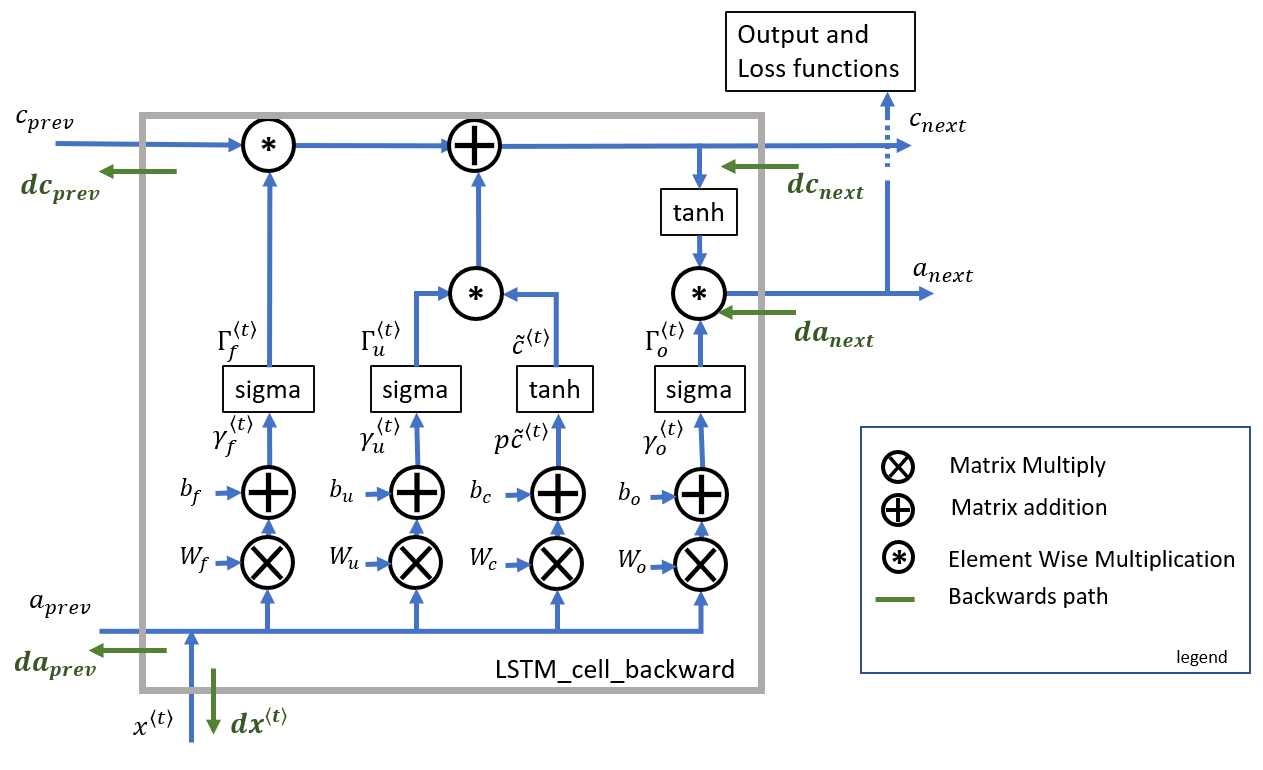

In [21]:
Image(filename="images/LSTM_cell_backward_rev3a_c2.png", width=900, height=500)

### <font color='indigo'>Gate derivatives</font>

Note the location of the gate derivatives ($\gamma$..) between the dense layer and the activation function (see graphic). This is convenient for computing parameter derivatives in the next step. 

$d\gamma_o^{\langle t \rangle} = da_{next}*\tanh(c_{next}) * \Gamma_o^{\langle t \rangle}*\left(1-\Gamma_o^{\langle t \rangle}\right)$

$dp\widetilde{c}^{\langle t \rangle} = \left(dc_{next}*\Gamma_u^{\langle t \rangle}+ \Gamma_o^{\langle t \rangle}* (1-\tanh^2(c_{next})) * \Gamma_u^{\langle t \rangle} * da_{next} \right) * \left(1-\left(\widetilde c^{\langle t \rangle}\right)^2\right) $

$d\gamma_u^{\langle t \rangle} = \left(dc_{next}*\widetilde{c}^{\langle t \rangle} + \Gamma_o^{\langle t \rangle}* (1-\tanh^2(c_{next})) * \widetilde{c}^{\langle t \rangle} * da_{next}\right)*\Gamma_u^{\langle t \rangle}*\left(1-\Gamma_u^{\langle t \rangle}\right)$

$d\gamma_f^{\langle t \rangle} = \left(dc_{next}* c_{prev} + \Gamma_o^{\langle t \rangle} * (1-\tanh^2(c_{next})) * c_{prev} * da_{next}\right)*\Gamma_f^{\langle t \rangle}*\left(1-\Gamma_f^{\langle t \rangle}\right)$


### <font color='Indigo'>Parameter derivatives</font>

$ dW_f = d\gamma_f^{\langle t \rangle} \begin{bmatrix} a_{prev} \\ x_t\end{bmatrix}^T  $
$ dW_u = d\gamma_u^{\langle t \rangle} \begin{bmatrix} a_{prev} \\ x_t\end{bmatrix}^T  $
$ dW_c = dp\widetilde c^{\langle t \rangle} \begin{bmatrix} a_{prev} \\ x_t\end{bmatrix}^T $
$ dW_o = d\gamma_o^{\langle t \rangle} \begin{bmatrix} a_{prev} \\ x_t\end{bmatrix}^T $

To calculate $db_f, db_u, db_c, db_o$ you just need to sum across all 'm' examples (axis= 1) on $d\gamma_f^{\langle t \rangle}, d\gamma_u^{\langle t \rangle}, dp\widetilde c^{\langle t \rangle}, d\gamma_o^{\langle t \rangle}$ respectively. Note that you should have the `keepdims = True` option.

$\displaystyle db_f = \sum_{batch}d\gamma_f^{\langle t \rangle}$
$\displaystyle db_u = \sum_{batch}d\gamma_u^{\langle t \rangle}$
$\displaystyle db_c = \sum_{batch}d\gamma_c^{\langle t \rangle}$
$\displaystyle db_o = \sum_{batch}d\gamma_o^{\langle t \rangle}$

Finally, you will compute the derivative with respect to the previous hidden state, previous memory state, and input.

$ da_{prev} = W_f^T d\gamma_f^{\langle t \rangle} + W_u^T   d\gamma_u^{\langle t \rangle}+ W_c^T dp\widetilde c^{\langle t \rangle} + W_o^T d\gamma_o^{\langle t \rangle} $

Here, to account for concatenation, the weights for equations 19 are the first n_a, (i.e. $W_f = W_f[:,:n_a]$ etc...)

$ dc_{prev} = dc_{next}*\Gamma_f^{\langle t \rangle} + \Gamma_o^{\langle t \rangle} * (1- \tanh^2(c_{next}))*\Gamma_f^{\langle t \rangle}*da_{next} $

$ dx^{\langle t \rangle} = W_f^T d\gamma_f^{\langle t \rangle} + W_u^T  d\gamma_u^{\langle t \rangle}+ W_c^T dp\widetilde c^{\langle t \rangle} + W_o^T d\gamma_o^{\langle t \rangle}$

where the weights for equation 21 are from n_a to the end, (i.e. $W_f = W_f[:,n_a:]$ etc...)

**Exercise:** Implement `lstm_cell_backward`. 
  
    
Note: In the code:
$d\gamma_o^{\langle t \rangle}$ is represented by  `dot`,    
$dp\widetilde{c}^{\langle t \rangle}$ is represented by  `dcct`,  
$d\gamma_u^{\langle t \rangle}$ is represented by  `dit`,  
$d\gamma_f^{\langle t \rangle}$ is represented by  `dft`

In [22]:
def lstm_cell_backward(da_next, dc_next, cache):
    """
    Implement the backward pass for the LSTM-cell (single time-step).

    Arguments:
    da_next -- Gradients of next hidden state, of shape (n_a, m)
    dc_next -- Gradients of next cell state, of shape (n_a, m)
    cache -- cache storing information from the forward pass

    Returns:
    gradients -- python dictionary containing:
            dxt -- Gradient of input data at time-step t, of shape (n_x, m)
            da_prev -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
            dc_prev -- Gradient w.r.t. the previous memory state, of shape (n_a, m, T_x)
            dWf -- Gradient w.r.t. the weight matrix of the forget gate, shape (n_a, n_a + n_x)
            dWi -- Gradient w.r.t. the weight matrix of the update gate, shape (n_a, n_a + n_x)
            dWc -- Gradient w.r.t. the weight matrix of the memory gate, shape (n_a, n_a + n_x)
            dWo -- Gradient w.r.t. the weight matrix of the output gate, shape (n_a, n_a + n_x)
            dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
            dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
            dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
            dbo -- Gradient w.r.t. biases of the output gate, of shape (n_a, 1)
    """

    # Retrieve information from "cache"
    (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters) = cache
    
    # Retrieve dimensions from xt's and a_next's shape
    n_x, m = xt.shape
    n_a, m = a_next.shape
    
    # Compute gates related derivatives
    dot  = da_next*np.tanh(c_next)*ot*(1-ot)
    dcct = (dc_next*it+ot*(1-np.square(np.tanh(c_next)))*it*da_next)*(1-np.square(cct))
    dit  = (dc_next*cct+ot*(1-np.square(np.tanh(c_next)))*cct*da_next)*it*(1-it)
    dft  = (dc_next*c_prev+ot*(1-np.square(np.tanh(c_next)))*c_prev*da_next)*ft*(1-ft)
    
    # Compute parameters related derivatives.
    dWf = np.dot(dft,np.concatenate((a_prev, xt), axis=0).T)
    dWi = np.dot(dit,np.concatenate((a_prev, xt), axis=0).T)
    dWc = np.dot(dcct,np.concatenate((a_prev, xt), axis=0).T)
    dWo = np.dot(dot,np.concatenate((a_prev, xt), axis=0).T)
    dbf = np.sum(dft,axis=1,keepdims=True)
    dbi = np.sum(dit,axis=1,keepdims=True)
    dbc = np.sum(dcct,axis=1,keepdims=True)
    dbo = np.sum(dot,axis=1,keepdims=True)

    # Compute derivatives w.r.t previous hidden state, previous memory state and input. 
    da_prev = np.dot(parameters['Wf'][:,:n_a].T,dft) + \
              np.dot(parameters['Wi'][:,:n_a].T,dit) + \
              np.dot(parameters['Wc'][:,:n_a].T,dcct)+ \
              np.dot(parameters['Wo'][:,:n_a].T,dot)
    
    dc_prev = dc_next*ft+ot*(1-np.square(np.tanh(c_next)))*ft*da_next
    
    dxt = np.dot(parameters['Wf'][:,n_a:].T,dft) + \
          np.dot(parameters['Wi'][:,n_a:].T,dit) + \
          np.dot(parameters['Wc'][:,n_a:].T,dcct)+ \
          np.dot(parameters['Wo'][:,n_a:].T,dot)
    
    # Save gradients in dictionary
    gradients = {"dxt": dxt, 
                 "da_prev": da_prev, 
                 "dc_prev": dc_prev, 
                 "dWf": dWf,
                 "dbf": dbf, 
                 "dWi": dWi,
                 "dbi": dbi,
                 "dWc": dWc,
                 "dbc": dbc, 
                 "dWo": dWo,
                 "dbo": dbo}
    return gradients

In [23]:
np.random.seed(1)
xt_tmp = np.random.randn(3,10)
a_prev_tmp = np.random.randn(5,10)
c_prev_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5+3)
parameters_tmp['bf'] = np.random.randn(5,1)
parameters_tmp['Wi'] = np.random.randn(5, 5+3)
parameters_tmp['bi'] = np.random.randn(5,1)
parameters_tmp['Wo'] = np.random.randn(5, 5+3)
parameters_tmp['bo'] = np.random.randn(5,1)
parameters_tmp['Wc'] = np.random.randn(5, 5+3)
parameters_tmp['bc'] = np.random.randn(5,1)
parameters_tmp['Wy'] = np.random.randn(2,5)
parameters_tmp['by'] = np.random.randn(2,1)

a_next_tmp, c_next_tmp, yt_tmp, cache_tmp = lstm_cell_forward(xt_tmp, a_prev_tmp, c_prev_tmp, parameters_tmp)

da_next_tmp = np.random.randn(5,10)
dc_next_tmp = np.random.randn(5,10)
gradients_tmp = lstm_cell_backward(da_next_tmp, dc_next_tmp, cache_tmp)
print("gradients[\"dxt\"][1][2] =", gradients_tmp["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients_tmp["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients_tmp["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients_tmp["da_prev"].shape)
print("gradients[\"dc_prev\"][2][3] =", gradients_tmp["dc_prev"][2][3])
print("gradients[\"dc_prev\"].shape =", gradients_tmp["dc_prev"].shape)
print("gradients[\"dWf\"][3][1] =", gradients_tmp["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients_tmp["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients_tmp["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients_tmp["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients_tmp["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients_tmp["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients_tmp["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients_tmp["dWo"].shape)
print("gradients[\"dbf\"][4]    =", gradients_tmp["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients_tmp["dbf"].shape)
print("gradients[\"dbi\"][4]    =", gradients_tmp["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients_tmp["dbi"].shape)
print("gradients[\"dbc\"][4]    =", gradients_tmp["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients_tmp["dbc"].shape)
print("gradients[\"dbo\"][4]    =", gradients_tmp["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients_tmp["dbo"].shape)

gradients["dxt"][1][2] = 3.23055911511
gradients["dxt"].shape = (3, 10)
gradients["da_prev"][2][3] = -0.0639621419711
gradients["da_prev"].shape = (5, 10)
gradients["dc_prev"][2][3] = 0.797522038797
gradients["dc_prev"].shape = (5, 10)
gradients["dWf"][3][1] = -0.147954838164
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = 1.05749805523
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = 2.30456216369
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = 0.331311595289
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4]    = [ 0.18864637]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4]    = [-0.40142491]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4]    = [ 0.25587763]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4]    = [ 0.13893342]
gradients["dbo"].shape = (5, 1)


### <font color='indigo'>Backward pass through the LSTM RNN</font>

This part is very similar to the `rnn_backward` function you implemented above. You will first create variables of the same dimension as your return variables. You will then iterate over all the time steps starting from the end and call the one step function you implemented for LSTM at each iteration. You will then update the parameters by summing them individually. Finally return a dictionary with the new gradients. 

**Instructions**: Implement the `lstm_backward` function. Create a for loop starting from $T_x$ and going backward. For each step call `lstm_cell_backward` and update the your old gradients by adding the new gradients to them. Note that `dxt` is not updated but is stored.

In [24]:
def lstm_backward(da, caches):
    
    """
    Implement the backward pass for the RNN with LSTM-cell (over a whole sequence).

    Arguments:
    da -- Gradients w.r.t the hidden states, numpy-array of shape (n_a, m, T_x)
    caches -- cache storing information from the forward pass (lstm_forward)

    Returns:
    gradients -- python dictionary containing:
    dx -- Gradient of inputs, of shape (n_x, m, T_x)
    da0 -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
    dWf -- Gradient w.r.t. the weight matrix of the forget gate, shape (n_a, n_a + n_x)
    dWi -- Gradient w.r.t. the weight matrix of the update gate, shape (n_a, n_a + n_x)
    dWc -- Gradient w.r.t. the weight matrix of the memory gate, shape (n_a, n_a + n_x)
    dWo -- Gradient w.r.t. the weight matrix of the save gate, shape (n_a, n_a + n_x)
    dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
    dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
    dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
    dbo -- Gradient w.r.t. biases of the save gate, of shape (n_a, 1)
    """

    # Retrieve values from the first cache (t=1) of caches.
    (caches, x) = caches
    (a1, c1, a0, c0, f1, i1, cc1, o1, x1, parameters) = caches[0]
    
    
    # Retrieve dimensions from da's and x1's shapes
    n_a, m, T_x = da.shape
    n_x, m = x1.shape
    
    # initialize the gradients with the right size
    
    dx = np.zeros((n_x, m, T_x))
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))
    dc_prevt = np.zeros((n_a, m))
    dWf = np.zeros((n_a, n_a + n_x))
    dWi = np.zeros((n_a, n_a + n_x))
    dWc = np.zeros((n_a, n_a + n_x))
    dWo = np.zeros((n_a, n_a + n_x))
    dbf = np.zeros((n_a, 1))
    dbi = np.zeros((n_a, 1))
    dbc = np.zeros((n_a, 1))
    dbo = np.zeros((n_a, 1))
    
    # loop back over the whole sequence
    for t in reversed(range(T_x)):
        # Compute all gradients using lstm_cell_backward
        gradients = lstm_cell_backward(da[:,:,t]+da_prevt,dc_prevt,caches[t])
        
        # Store or add the gradient to the parameters' previous step's gradient
        da_prevt = gradients["da_prev"]
        dc_prevt = gradients["dc_prev"]
        dx[:,:,t] = gradients["dxt"]
        dWf += gradients["dWf"]
        dWi += gradients["dWi"]
        dWc += gradients["dWc"]
        dWo += gradients["dWo"]
        dbf += gradients["dbf"]
        dbi += gradients["dbi"]
        dbc += gradients["dbc"]
        dbo += gradients["dbo"]

    # Set the first activation's gradient to the backpropagated gradient da_prev.
    da0 = gradients["da_prev"]
    
    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}
    
    return gradients

In [25]:
np.random.seed(1)
x_tmp = np.random.randn(3,10,7)
a0_tmp = np.random.randn(5,10)

parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5+3)
parameters_tmp['bf'] = np.random.randn(5,1)
parameters_tmp['Wi'] = np.random.randn(5, 5+3)
parameters_tmp['bi'] = np.random.randn(5,1)
parameters_tmp['Wo'] = np.random.randn(5, 5+3)
parameters_tmp['bo'] = np.random.randn(5,1)
parameters_tmp['Wc'] = np.random.randn(5, 5+3)
parameters_tmp['bc'] = np.random.randn(5,1)
parameters_tmp['Wy'] = np.zeros((2,5))       # unused, but needed for lstm_forward
parameters_tmp['by'] = np.zeros((2,1))       # unused, but needed for lstm_forward

a_tmp, y_tmp, c_tmp, caches_tmp = lstm_forward(x_tmp, a0_tmp, parameters_tmp)

da_tmp = np.random.randn(5, 10, 4)
gradients_tmp = lstm_backward(da_tmp, caches_tmp)

print("gradients[\"dx\"][1][2]  =", gradients_tmp["dx"][1][2])
print("gradients[\"dx\"].shape  =", gradients_tmp["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients_tmp["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients_tmp["da0"].shape)
print("gradients[\"dWf\"][3][1] =", gradients_tmp["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients_tmp["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients_tmp["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients_tmp["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients_tmp["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients_tmp["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients_tmp["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients_tmp["dWo"].shape)
print("gradients[\"dbf\"][4]    =", gradients_tmp["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients_tmp["dbf"].shape)
print("gradients[\"dbi\"][4]    =", gradients_tmp["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients_tmp["dbi"].shape)
print("gradients[\"dbc\"][4]    =", gradients_tmp["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients_tmp["dbc"].shape)
print("gradients[\"dbo\"][4]    =", gradients_tmp["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients_tmp["dbo"].shape)

gradients["dx"][1][2]  = [ 0.00218254  0.28205375 -0.48292508 -0.43281115]
gradients["dx"].shape  = (3, 10, 4)
gradients["da0"][2][3] = 0.312770310257
gradients["da0"].shape = (5, 10)
gradients["dWf"][3][1] = -0.0809802310938
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = 0.40512433093
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = -0.0793746735512
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = 0.038948775763
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4]    = [-0.15745657]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4]    = [-0.50848333]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4]    = [-0.42510818]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4]    = [-0.17958196]
gradients["dbo"].shape = (5, 1)
